In [1]:
import os 
import glob
import zipfile
import dolfyn as dlfn
import xarray as xr
import pandas as pd
import numpy as np
import math
import datetime
import matplotlib.dates as mdates
from pathlib import Path
from dolfyn.adp import api
from matplotlib import pyplot as plt
import matplotlib.dates as dt

In [2]:
# READ AD2CP FILES AND MERGE
wdir     = os.path.join('c:/','Users','sa01ld','OneDrive - SAMS','Projects','Autonaut-EE', 'Non-Acoustic data','process-raw')
zdir     = os.path.join('c:/','Users','sa01ld','OneDrive - SAMS','Projects','Autonaut-EE', 'Non-Acoustic data','process-raw','zipped-files')
indir    = os.path.join(wdir + '/*.sigVM')

# deal with the file formats. Change file extensions to zip from sigVM and unzip
fname =glob.glob(indir)

In [3]:
if fname:
    for i in fname:
        print(i)
        bn = os.path.splitext(os.path.basename(i))[0]
        old=i
        new=os.path.join(zdir,bn+'.zip')
        os.rename(old, new)
        
indir    = os.path.join(zdir + '/*.zip')        
fname =glob.glob(indir)
fname 

['c:/Users\\sa01ld\\OneDrive - SAMS\\Projects\\Autonaut-EE\\Non-Acoustic data\\process-raw\\zipped-files\\101512_20210803T080024UTC.zip',
 'c:/Users\\sa01ld\\OneDrive - SAMS\\Projects\\Autonaut-EE\\Non-Acoustic data\\process-raw\\zipped-files\\101512_20210803T115712UTC.zip',
 'c:/Users\\sa01ld\\OneDrive - SAMS\\Projects\\Autonaut-EE\\Non-Acoustic data\\process-raw\\zipped-files\\101512_20210803T122249UTC.zip',
 'c:/Users\\sa01ld\\OneDrive - SAMS\\Projects\\Autonaut-EE\\Non-Acoustic data\\process-raw\\zipped-files\\101512_20210803T123800UTC.zip',
 'c:/Users\\sa01ld\\OneDrive - SAMS\\Projects\\Autonaut-EE\\Non-Acoustic data\\process-raw\\zipped-files\\101512_20210803T134245UTC.zip',
 'c:/Users\\sa01ld\\OneDrive - SAMS\\Projects\\Autonaut-EE\\Non-Acoustic data\\process-raw\\zipped-files\\101512_20210803T134759UTC.zip',
 'c:/Users\\sa01ld\\OneDrive - SAMS\\Projects\\Autonaut-EE\\Non-Acoustic data\\process-raw\\zipped-files\\101512_20210803T135245UTC.zip',
 'c:/Users\\sa01ld\\OneDrive - SAM

In [4]:
if fname:
    for i in fname:
        with zipfile.ZipFile(i,"r") as zip_ref:
            zip_ref.extractall(zdir)

# GET ALL AD2CP FILES 
ad2cpdir= os.path.join(zdir + '/*.AD2CP')
fname =glob.glob(ad2cpdir)

# GET ALL NMEA FILES
ndir     = os.path.join('c:/','Users','sa01ld','OneDrive - SAMS','Projects','Autonaut-EE', 'Non-Acoustic data','batch-process-GNSS')
nmdir    = os.path.join(ndir + '/*_Data')
nmname =glob.glob(nmdir)

In [5]:
First=True
if First:
    print('n')

n


# merge the data sets

In [6]:
first=True
xx=0
adppath = Path('data/ADCP.nc')
navpath = Path('data/nav.csv')

if not adppath.is_file():
    for i,j in zip(fname,nmname):
            if i in ['c:/Users\\sa01ld\\OneDrive - SAMS\\Projects\\Autonaut-EE\\Non-Acoustic data\\process-raw\\zipped-files\\101512_20211008T190648UTC.AD2CP','c:/Users\\sa01ld\\OneDrive - SAMS\\Projects\\Autonaut-EE\\Non-Acoustic data\\process-raw\\zipped-files\\101512_20211008T130648UTC.AD2CP','c:/Users\\sa01ld\\OneDrive - SAMS\\Projects\\Autonaut-EE\\Non-Acoustic data\\process-raw\\zipped-files\\101512_20210805T010703UTC.AD2CP']:
                bn = os.path.splitext(os.path.basename(i))[0] # unique file ID
                print('skipping ' + bn)
                continue

            # read csv files and extract lat and long data
            bn = os.path.splitext(os.path.basename(i))[0] # unique file ID
            print('Checking ' + bn)

            if not navpath.is_file():
                csvpath=os.path.join(j,bn+'.csv')
                df=pd.read_csv(csvpath) # nav data 


                asv=np.square(df.GPSEast.values)+np.square(df.GPSNorth.values)
                asv=np.sqrt(asv) 

                adcp=np.square(df.VEast.values)+np.square(df.VNorth.values)
                adcp=np.sqrt(adcp) 
                time=df.Date_Time
                timex = np.array(time, dtype='datetime64[s]')

                # make new dataframe
                ndf = df[['Date_Time', 'EnsNo','GPSEast','GPSNorth','GPSHeading', 'SHeading','VEast','VNorth']].copy()
                ndf.insert(1, "adcpVel", adcp,allow_duplicates=True)
                ndf.insert(1, "asvVel", asv,allow_duplicates=True)
                if xx>0:
                    # concatenate the datframes
                    csdf=pd.concat([csdf, ndf])
                else:
                    csdf=ndf

                xx=xx+1  
            
            da = dlfn.read(i) # adcp data  
            da = dlfn.rotate2(da, 'earth', inplace=True)

            # merge the ADCP dat sets
            if first:
                first = False
                ds=da
            else:
                ds=xr.merge([ds,da])
    # save to net cdf       
    ds.to_netcdf(path='data/ADCP.nc')
    csdf.to_csv('data/nav.csv', index=False)
    
else:
    ds = xr.open_dataset('data/ADCP.nc')
    csdf = pd.read_csv('data/nav.csv') # nav data 
        

In [7]:
csdf

,Date_Time,asvVel,adcpVel,EnsNo,GPSEast,GPSNorth,GPSHeading,SHeading,VEast,VNorth
0,2021-08-03T08:21:32.43,0.115802,NaN,1265,-0.033,-0.111,53.76,42.15,NaN,NaN
1,2021-08-03T08:21:33.43,0.271207,NaN,1266,0.247,-0.112,53.77,42.10,NaN,NaN
2,2021-08-03T08:21:34.43,0.221387,NaN,1267,0.204,-0.086,53.79,42.11,NaN,NaN
3,2021-08-03T08:21:35.43,0.163414,NaN,1268,0.152,0.060,53.81,42.08,NaN,NaN
4,2021-08-03T08:21:36.43,0.235017,NaN,1269,-0.228,0.057,53.83,42.21,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
349454,2021-10-14T02:19:26.43,0.843977,0.555155,8158,-0.741,-0.404,253.29,217.70,-0.386,-0.399
349455,2021-10-14T02:19:27.43,0.483028,0.375299,8159,0.054,-0.480,252.19,214.86,0.175,-0.332
349456,2021-10-14T02:19:28.43,0.128226,0.485242,8160,0.101,-0.079,249.96,211.44,0.286,-0.392
349457,2021-10-14T02:19:29.43,1.012356,0.735099,8161,-1.007,0.104,243.75,212.34,-0.667,-0.309


In [8]:
# # apply correlation filter

# # look at the correlation values
# %matplotlib inline
# ds.corr.sel(beam=1, range=slice(0,10)).plot()

# # clean the data with threshold of 50%
# # edf = api.clean.correlation_filter(ds, thresh=50)

# # rotate to earth coordinates
# edf = dlfn.rotate2(ds, 'earth', inplace=True)
            
 

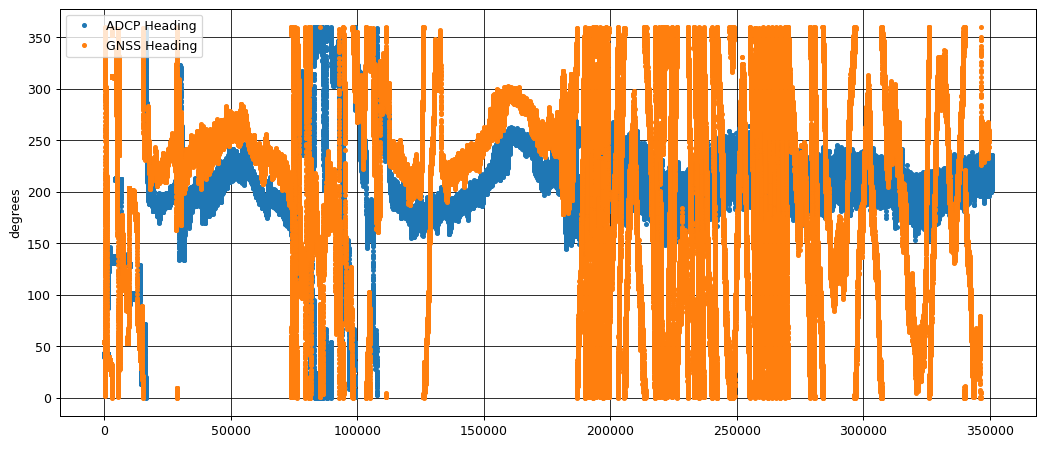

In [9]:

# surface current values
dv_east=np.mean(ds.vel.sel(dir='E', range=slice(0,5)).values,axis=0)
dv_north=np.mean(ds.vel.sel(dir='N', range=slice(0,5)).values,axis=0)
dv_time=ds.time.values+3600
dv_time = np.array(dv_time, dtype='datetime64[s]')

ev=np.square(dv_east)+np.square(dv_north)
ev=np.sqrt(ev) 


#     %matplotlib inline
#     fig, ax = plt.subplots(figsize=[14, 6], sharex=True, dpi=90)
#     plt.plot(timex,asv,'.' ,label="GPS Velocity")
#     plt.plot(dv_time,ev, '.',label="earth-rotated ADCP Velocity")
#     plt.xlabel("Time")
#     plt.ylabel("m/s")
#     plt.legend(loc='upper left')
#     plt.grid(visible='True', which='major', axis='both', c='black',alpha=0.8)
#     fig.autofmt_xdate()
# #                 ax.set_xlim([datetime.date(2021, 8, 27), datetime.date(2021, 8, 28)])
#     figfile=os.path.join('figures/' +'gps_speed_vs_earth-rotated-adcp_speed_processed'+ bn + '.png')
#     fig.savefig(figfile, dpi=100, facecolor='white')
#     plt.show()

fig, ax = plt.subplots(figsize=[14, 6], sharex=True, dpi=90)
plt.plot(ds.heading_bt.values, '.',label="ADCP Heading")
plt.plot(csdf.GPSHeading.values,'.', label="GNSS Heading")
plt.xlabel(" ")
plt.ylabel("degrees")               
plt.legend(loc='upper left')
plt.grid(visible='True', which='major', axis='both', c='black',alpha=0.8)
figfile=os.path.join('figures/' +'headings.png')
fig.savefig(figfile, dpi=100, facecolor='white')
plt.show()

                

        

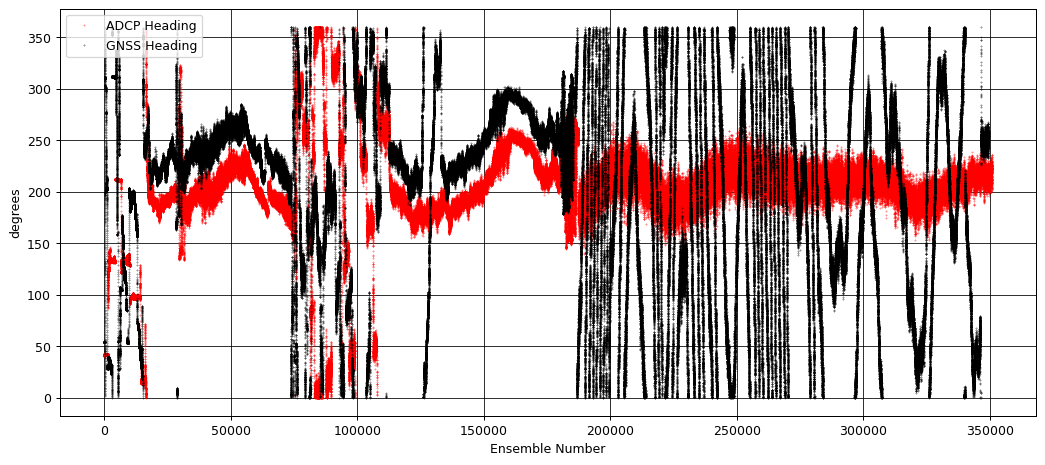

In [10]:
%matplotlib inline
fig, ax = plt.subplots(figsize=[14, 6], sharex=True, dpi=90)
plt.plot(ds.heading_bt.values, '.',color='red',markersize=0.5,label="ADCP Heading")
plt.plot(csdf.GPSHeading.values,'.',color='black',markersize=0.5, label="GNSS Heading")
plt.xlabel("Ensemble Number")
plt.grid(visible='True', which='major', axis='both', c='black',alpha=0.8)
plt.ylabel("degrees")  
plt.legend(loc='upper left')
figfile=os.path.join('figures/' +'headings.png')
fig.savefig(figfile, dpi=100, facecolor='white')
plt.show()

# Plot the data

NameError: name 'timex' is not defined

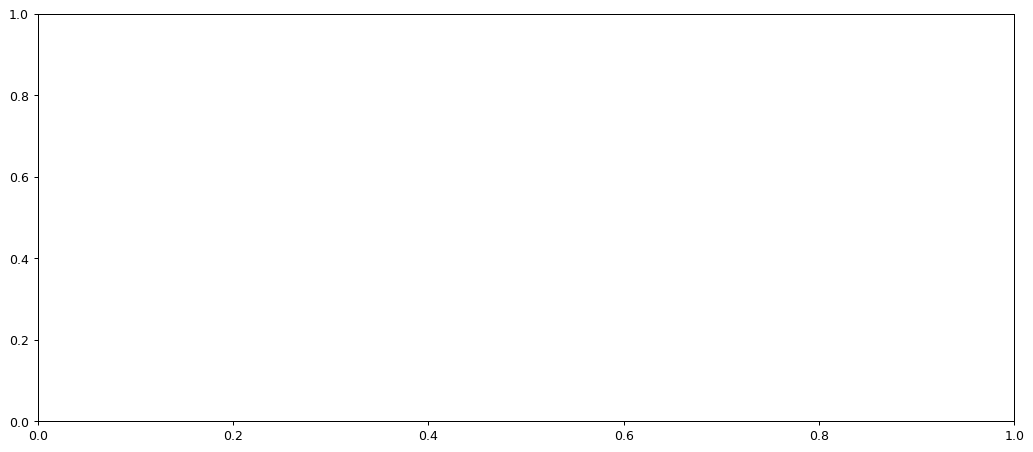

In [11]:
%matplotlib inline
fig, ax = plt.subplots(figsize=[14, 6], sharex=True, dpi=90)
plt.plot(timex,asv, label="GPS Velocity")
plt.plot(timex,adcp, label="ADCP Velocity")
plt.xlabel("Time")
plt.ylabel("m/s")
plt.legend(loc='upper left')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1000)) 
plt.grid(visible='True', which='major', axis='both', c='black',alpha=0.8)
fig.autofmt_xdate()
figfile=os.path.join('figures/' +'gps_speed_vs_adcp_speed_processed'+ bn + '.png')
fig.savefig(figfile, dpi=100, facecolor='white')
plt.show()

In [ ]:
da.ensemble.values

In [ ]:
not xx

In [ ]:
# get moving average
a_series = pd.Series(ev)
rolling_window_obj = a_series.rolling(50)
ra_ev = rolling_window_obj.mean()
ra_ev.size

a_series = pd.Series(asv)
rolling_window_obj = a_series.rolling(50)
ra_asv = rolling_window_obj.mean()
ra_asv.size


In [ ]:
%matplotlib inline
fig, ax = plt.subplots(figsize=[14, 6], sharex=True, dpi=90)
plt.plot(timex,asv, label="GPS Velocity")
plt.plot(dv_time,ev, label="earth-rotated ADCP Velocity")
plt.plot(timex,ra_asv, color='yellow', linestyle='dashed', linewidth=2,label="ship velocity moving average")
plt.plot(dv_time,ra_ev, color='black', linestyle='dashed', linewidth=2,label="adcp velocity moving average")
plt.xlabel("Time")
plt.ylabel("m/s")
plt.legend(loc='upper left')
plt.grid(visible='True', which='major', axis='both', c='black',alpha=0.8)
fig.autofmt_xdate()
#                 ax.set_xlim([datetime.date(2021, 8, 27), datetime.date(2021, 8, 28)])
figfile=os.path.join('figures/' +'gps_speed_vs_earth-rotated-adcp_speed_processed'+ bn + '.png')
fig.savefig(figfile, dpi=100, facecolor='white')
plt.show()

In [ ]:
# try integrate the values for a depth average
v_east=da.vel.sel(dir='E').values
z=da.range.values
dz=np.diff(z)
v_east=v_east.T
dac=np.trapz(v_east,x=z)
plt.plot(dac)

In [ ]:
# some fake data
data = ds.corr
# evaluate the histogram
values, base = np.histogram(data, bins=40)
#evaluate the cumulative
cumulative = np.cumsum(values)
# plot the cumulative function
plt.plot(base[:-1], cumulative, c='blue')
#plot the survival function
plt.plot(base[:-1], len(data)-cumulative, c='green')

plt.show()

In [ ]:
%matplotlib inline
ds.vel.sel(dir=1, range=slice(0,70)).plot()

Earth: When the data object is in ‘earth’ coordinates, the first dimension of vectors are: [East, North, Up, …]. This coordinate system is also sometimes denoted as “ENU”. If the declination is set the earth coordinate system is “True-East, True-North, Up” otherwise, East and North are magnetic. See the Declination Handling section for further details on setting declination.

In [ ]:
bn

In [ ]:
Evel=dd.vel.sel(dir=1,range=5)
Nvel=dd.vel.sel(dir=2,range=5)


In [ ]:
%matplotlib inline
ds.corr.sel(beam=1, range=slice(0,70)).plot()

In [ ]:
ds = api.clean.correlation_filter(ds, thresh=50)

%matplotlib inline
ds.corr.sel(beam=1, range=slice(0,70)).plot()

In [ ]:
ds_avg['U_mag'] = ds_avg.velds.U_mag
ds_avg['U_dir'] = ds_avg.velds.U_dir
ds_avg['U_dir'].data = dlfn.tools.misc.convert_degrees(ds_avg['U_dir'].values, tidal_mode=True)

%matplotlib inline
ax = plt.figure(figsize=(12,8)).add_axes([.14, .14, .8, .74])
# Plot the horizontal velocity magnitude
t = dlfn.time.dt642date(ds_avg.time)
plt.pcolormesh(t, ds_avg.range, ds_avg['U_mag'], cmap='Blues', shading='nearest')
# Plot the water surface
ax.plot(t, ds_avg.depth)

# Set up time on x-axis
ax.set_xlabel('Time')
ax.xaxis.set_major_formatter(dt.DateFormatter('%H:%M'))

ax.set_ylabel('Altitude [m]')
ax.set_ylim([0, 12])
plt.colorbar(label='Horizontal Vel [m/s]')